In [124]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
import graphviz
import re


In [129]:
#@title Helper functions
def proc_data(df, dropPassenger = True):
    
    split_ids = df["PassengerId"].str.split("_", expand=True)
    df["GroupId"] = split_ids[0].astype("int32")
    df["IndividualId"] = split_ids[1].astype("int32")
    
    df["Cabin"] = df["Cabin"].fillna("unknown/9999/unknown")
    split_cabins = df["Cabin"].str.split("/", expand=True)
    df["Deck"] = split_cabins[0].astype("category")
    df["CabinNum"] = split_cabins[1].astype("int32")
    df["CabinSide"] = split_cabins[2].astype("category")
    
    df["HomePlanet"] = df["HomePlanet"].fillna("unknown").astype("category")
    df["Destination"] = df["Destination"].fillna("unknown").astype("category")
    df["Name"] = df["Name"].fillna("unknown").astype("string")
    df["Age"] = df["Age"].fillna(df["Age"].median()).astype("int32")

    for col in spends:
        df[col] = df[col].fillna(0).astype("int32")
        
    imputer = KNNImputer(n_neighbors=5, weights='uniform')
    df[['VIP', 'CryoSleep']] = imputer.fit_transform(df[['VIP', 'CryoSleep']])
    df['VIP'] = df['VIP'].astype("int8")
    df['CryoSleep'] = df['CryoSleep'].astype("int8")
    if "Transported" in df:
        df["Transported"] = df["Transported"].astype("int8")

    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    if dropPassenger:
        df.drop(columns=["PassengerId"], inplace=True)
    df.drop(columns=["Cabin"], inplace=True)

def xs_y(df):
    xs = df[cats+conts+bools].copy()
    return xs, df[dep] if dep in df else None

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

def subm(preds, suff):
    tst_df["Transported"] = preds.astype("bool")
    sub_df = tst_df[["PassengerId", "Transported"]]
    sub_df.to_csv(f"sub-{suff}.csv", index = False)


In [130]:
comp = "spaceship-titanic"
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [131]:
df = pd.read_csv(path/"train.csv")
tst_df = pd.read_csv(path/"test.csv")
columns = df.columns
conts = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "GroupId", "IndividualId", "CabinNum"]
spends = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
cats = ["HomePlanet", "Destination", "Deck", "CabinSide"]
bools = ["VIP", "CryoSleep"]
dep = "Transported"
print(f"All columns: {columns}")
print(f"Continuous columns: {conts}")
print(f"Spending columns: {spends}")
print(f"Categorical columns: {cats}")
print(f"Dependent columns: {dep}")



All columns: Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
Continuous columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupId', 'IndividualId', 'CabinNum']
Spending columns: ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical columns: ['HomePlanet', 'Destination', 'Deck', 'CabinSide']
Dependent columns: Transported


In [132]:
print("Before processing:")
df.info()
proc_data(df)
print("After processing:")
df.info()

Before processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
After processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns)

In [133]:
trn_df, val_df = train_test_split(df, test_size = 0.25)
trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [134]:
tst_df
proc_data(tst_df, dropPassenger=False)
tst_df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,GroupId,IndividualId,Deck,CabinNum,CabinSide
0,0013_01,0,1,2,27,0,0,0,0,0,0,Nelly Carsoning,13,1,6,3,1
1,0018_01,0,0,2,19,0,0,9,0,2823,0,Lerome Peckers,18,1,5,4,1
2,0019_01,1,1,0,31,0,0,0,0,0,0,Sabih Unhearfus,19,1,2,0,1
3,0021_01,1,0,2,38,0,0,6652,0,181,585,Meratz Caltilter,21,1,2,1,1
4,0023_01,0,0,2,20,0,10,0,635,0,0,Brence Harperez,23,1,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,0,1,2,34,0,0,0,0,0,0,Jeron Peter,9266,2,6,1496,1
4273,9269_01,0,0,2,42,0,0,847,17,10,144,Matty Scheron,9269,1,8,9999,2
4274,9271_01,2,1,0,26,0,0,0,0,0,0,Jayrin Pore,9271,1,3,296,0
4275,9273_01,1,0,3,26,0,0,2680,0,0,523,Kitakan Conale,9273,1,3,297,0


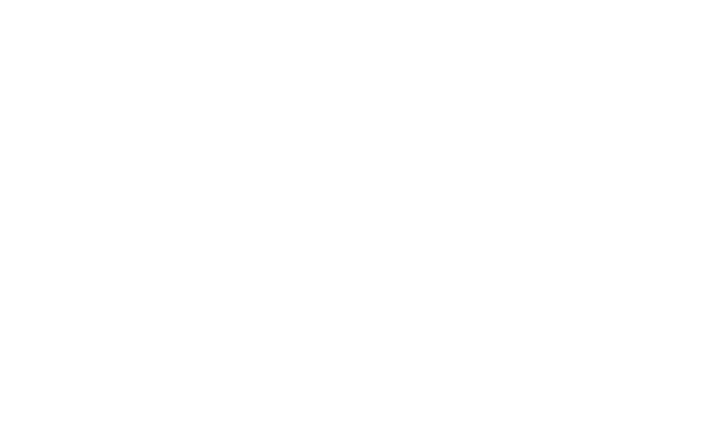

In [135]:
m = DecisionTreeClassifier(min_samples_leaf=50).fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=10)


In [136]:
mean_absolute_error(val_y, m.predict(val_xs))

0.21803127874885003

In [137]:
tst_xs, _ = xs_y(tst_df)
subm(m.predict(tst_xs), "tree")


In [138]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('sub-tree.csv', 'initial tree model', comp)

100%|██████████| 56.5k/56.5k [00:00<00:00, 84.9kB/s]
